In [124]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import time
import re
import random

In [2]:
tf.debugging.set_log_device_placement(False)
np.random.seed(42)

In [4]:
full_df = pd.read_csv('../../full_dataset.csv') # change path to where you have downloaded the dataset
df = full_df["NER"] # extracting the correct column

In [5]:
del full_df # remove full_df from memory

In [9]:
print(df.info()) # print out info from NER column

<class 'pandas.core.series.Series'>
RangeIndex: 2231142 entries, 0 to 2231141
Series name: NER
Non-Null Count    Dtype 
--------------    ----- 
2231142 non-null  object
dtypes: object(1)
memory usage: 17.0+ MB
None


In [7]:
def make_into_item_list(s): # function to turn a string into a list of items
    s = s[1:-1] # remove the first and last character of the input
    my_list = []
    substring = ''
    done = True
    my_set = {',',' '}
    for char in s: # loop over the string and use substring to store lowercase versions of the ingredients, appending it to a list after the whole word is consumed
        if char == '"':
            if done == True:
                done = False
                continue
            my_list.append(substring)
            substring = ''
            done = True
            continue
        elif char == ',':
            continue
        elif char == ' ':
            if done == True:
                continue
        elif char == '-':
            substring += ' '
            continue
        substring += char.lower()
    return my_list

def tokenize(ingredients): # use a simple regex to clean ingredients and return (initially used for tokenizing but that logic was removed since I stopped using it)
    ingredient_cleaned = re.sub(r"[^\w\s]","",ingredients)
    return ingredient_cleaned

In [8]:
unique_items = dict() # use a dictionary to keep track of items 
i = 0
recipe_ingredients = []

for row in df[:200000]: # loop over each row (only 200,000 of them) from the df 
    item_list = make_into_item_list(row) # make a list of ingredients from the string
    for item in item_list: # update the dictionary to keep track of the number of items 
        if item not in unique_items:
            unique_items[item] = 1
        else:
            unique_items[item] += 1
    tokenized_list = [tokenize(ingredient) for ingredient in item_list] # run each item into the tokenizer (no real purpose at the moment besides the regex
    recipe_ingredients.append(tokenized_list) # append the recipe
    i+=1

# a few print statements to show what is happening
print(row)
print(make_into_item_list(row))
print(set(make_into_item_list(row)))
print(i)
print(len(unique_items))
print(len(recipe_ingredients))

["plain yogurt", "cucumber", "raisins", "garlic", "salt", "walnuts", "dill"]
['plain yogurt', 'cucumber', 'raisins', 'garlic', 'salt', 'walnuts', 'dill']
{'walnuts', 'cucumber', 'salt', 'raisins', 'plain yogurt', 'garlic', 'dill'}
200000
22310
200000


In [10]:
w2v = Word2Vec(sentences=recipe_ingredients,vector_size=1000,window=5,workers=4,min_count=2,sg=1) 
# a Word2Vec model from gensim resulting in 1000 sized vectors using a context window of 5, 4 threads, a minimum word count of 2, and using SkipGram instead of CBOW

In [11]:
w2v.save("ingredient_word2vec_half_1000.model") # save the model

In [12]:
model = Word2Vec.load("ingredient_word2vec_half_1000.model") # load the model for use

In [13]:
errors = [] # keep track of errors
issue_flag = False
recipe_vectors = [] 
for i in range(len(recipe_ingredients[:200000])): # loop over the recipes
    temp = [] # keep track of normalized ingredients in recipes

    for ingredient in recipe_ingredients[i]: # loop over the ingredients in a recipe
        try:
            vector = model.wv[ingredient] # get the embedded ingredient
            norm = np.linalg.norm(vector) # normalize it 
            if norm == 0:
                normed_vector = vector/(1e-12) # account for division by 0
            else:
                normed_vector = vector/ norm
            temp.append(normed_vector)
        except KeyError:
            errors.append(recipe_ingredients[i]) # incase of an error where the ingredient doesn't appear in Word2Vec
            issue_flag = True
            break # early break to stop reading ingredients
    if issue_flag:
        issue_flag = False
        continue # reset flag and go to next recipe
    recipe_vectors.append(temp) # add normalized ingredient recipe to list
    
print(len(errors)) # report the number of errors

11731


In [14]:
averaged_recipe_list = []
for recipe in recipe_vectors: # go over each recipe and compute the mean, if there is a NaN we skip
    res = np.mean(recipe,axis=0)
    if type(res) == np.float64 and math.isnan(res):
        continue
    else:
        averaged_recipe_list.append(res)

C:\Users\Jaz\anaconda3\envs\ml-gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Jaz\anaconda3\envs\ml-gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
inter_df = pd.DataFrame(averaged_recipe_list) # convert to dataframe for store purposes

In [18]:
renamed = {}
for i in range(1000): # dictionary for renaming columns
    renamed[i] = f"{i}"
inter_df.rename(columns = renamed,inplace=True)

In [20]:
inter_df.to_parquet('averaged_recipe_list_200k_df.parquet') # store as a parquet for faster loading

In [ ]:
averaged_recipe_list = pd.read_parquet('averaged_recipe_list_200k_df.parquet') # read in the parquet file

In [21]:
X_train, X_val = train_test_split(averaged_recipe_list,test_size = 0.2,random_state =42, shuffle=True) # do a 80/20 train val split

In [22]:
input_vector = Input(shape=(1000,)) # input size of 1000
encoded = Dense(512, activation='relu')(input_vector) # hidden layer of size 512
encoded = Dense(256, activation='relu')(encoded) # hidden layer of size 256
latent = Dense(128, activation='relu')(encoded) # latent space
decoded = Dense(256, activation='relu')(latent) # hidden layer of size 256
decoded = Dense(512, activation='relu')(decoded) # hidden layer of size 512
output_vector = Dense(1000, activation='linear')(decoded) # output of size 1000

autoencoder = Model(input_vector, output_vector) # create the autoencoder model

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # compile the model and set the optimizer with a custom learning rate, loss, and steps
                    loss='mse',
                    steps_per_execution=1)

autoencoder.summary() # print model summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 1000)              513000

In [23]:
X_train_v1 = np.array(X_train) # turn train and val lists into np.arrays (if not already) and turn those into tensors
X_val_v1 = np.array(X_val)
X_train_v1 = tf.convert_to_tensor(X_train_v1)
X_val_v1 = tf.convert_to_tensor(X_val_v1)

In [24]:
checkpoint_callback = ModelCheckpoint( # define the checkpointing to store intermediate models from each epoch
    filepath='models_200k_real/autoencoder_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

In [ ]:
# train the model with the callbacks
history = autoencoder.fit(
    X_train_v1, X_train_v1,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_v1, X_val_v1),
    callbacks=[checkpoint_callback],
    verbose=1
)

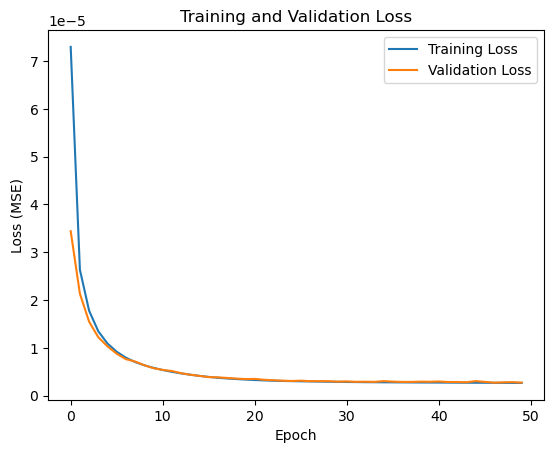

In [26]:
plt.plot(history.history['loss'], label='Training Loss') # plot the training and validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [27]:
save_model(autoencoder,'autoencoder_model_cuslr_linear_e50_b64_10pv_vec1000_real.keras') # save the model to a keras file for easy loading
# I used a weird naming scheme but it makes sense, autoencoder with custom learning rate, linear output, 50 epochs, 64 batch size, 10 percent of vectors,
# Word2Vec size 1000, and using real to denote final model (did not occur to me to name it final at the time) 

In [128]:
latent_representation = encoder.predict(np.concatenate((X_train_v1, X_val_v1), axis=0),batch_size=32) # create the latent representation and reconstruction
reconstruction = autoencoder.predict(np.concatenate((X_train_v1, X_val_v1), axis=0),batch_size=32)


5883/5883 [==============================] - 5s 785us/step


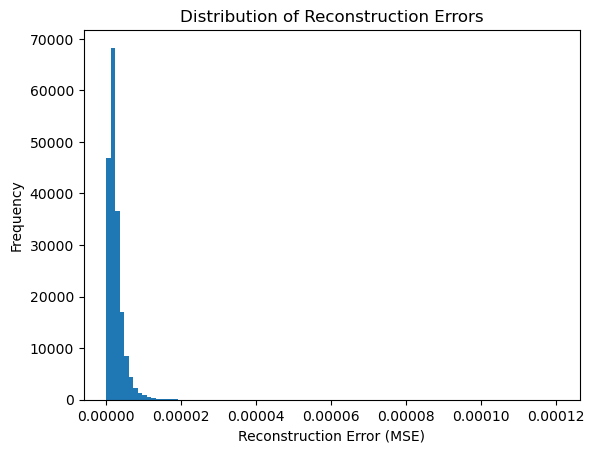

In [132]:
data = np.concatenate((X_train_v1, X_val_v1), axis=0) # create the full dataset again
data_flat = data.reshape(len(data), -1) # reshaping
recon_flat = reconstruction.reshape(len(reconstruction), -1)
mse_scores = np.mean(np.square(data_flat - recon_flat), axis=1) # take the mse to plot

plt.hist(mse_scores, bins=100) # create a histogram to see mse
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.show()

1/1 [==============================] - 0s 13ms/step


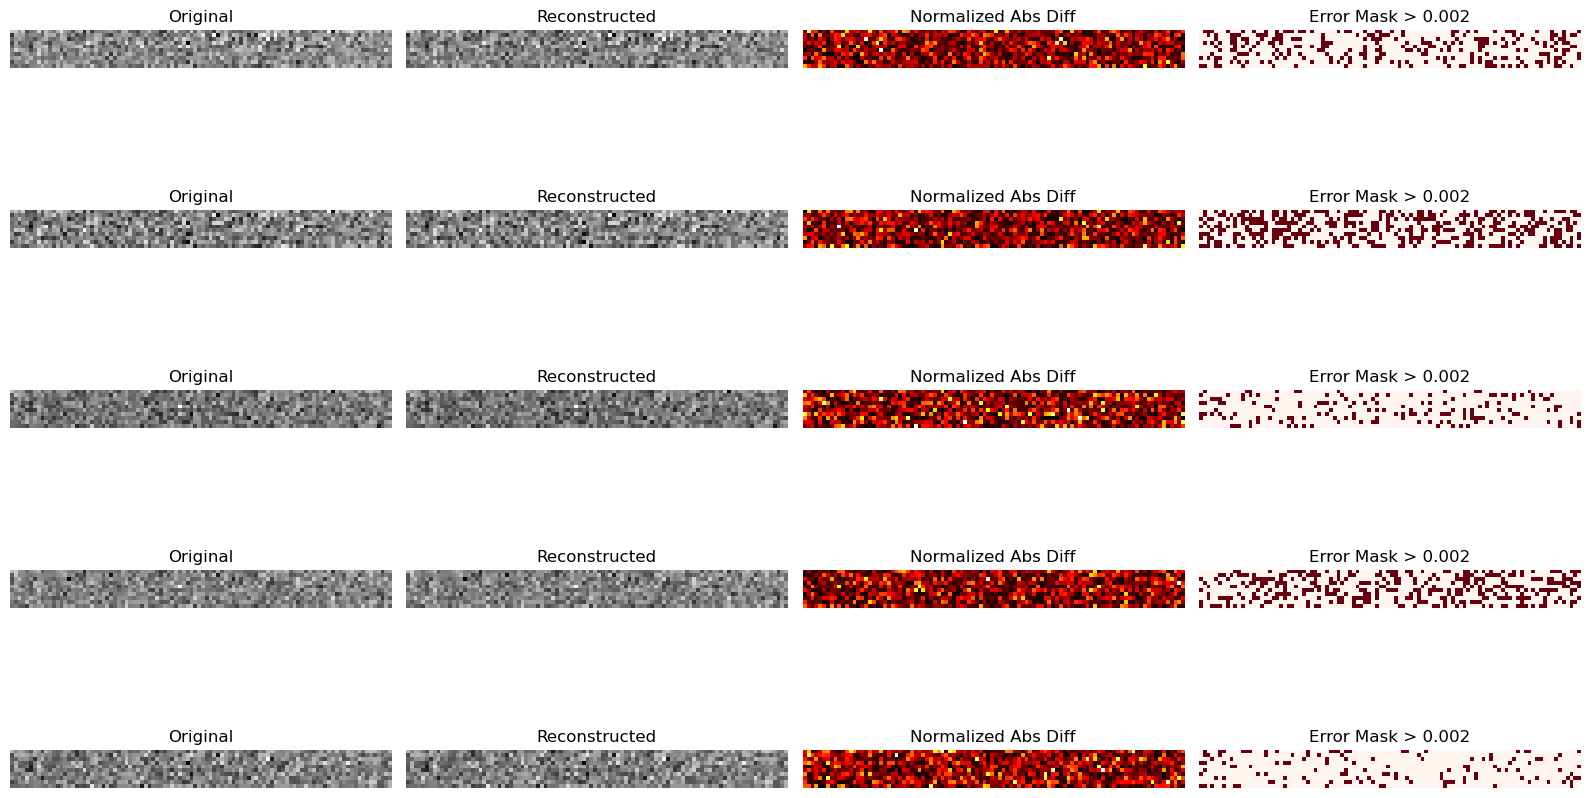

In [133]:
n_samples = 5
threshold = 2e-3 # set the error threshold for the mask plot
test_samples = data[np.random.choice(len(data), n_samples, replace=False)] # get n random samples from our data
reconstructed_samples = autoencoder.predict(test_samples) # reconstruct them by passing them through the autoencoder

fig, axes = plt.subplots(n_samples, 4, figsize=(16, 2 * n_samples)) # set up the 4 column plot

for i in range(n_samples):
    original = test_samples[i].reshape(10, 100) # a bunch of reshaping
    reconstructed = reconstructed_samples[i].reshape(10, 100)
    diff = np.abs(original - reconstructed) # calculate the absolute difference between the original and reconstruction
    norm_diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff) + 1e-12) # normalize it to better quanitfy the results
    mask = (diff > threshold).astype(float) # create the max by using the error threshold
    # now we make all the plots using cmap to show it all in a more sensible manner
    axes[i, 0].imshow(original, cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(reconstructed, cmap="gray")
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(norm_diff, cmap="hot")
    axes[i, 2].set_title("Normalized Abs Diff")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(mask, cmap="Reds")
    axes[i, 3].set_title(f"Error Mask > {threshold}")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

# you can use this to print out and compare the vectors but it takes up a lot of space
# for i in range(n_samples):
#     print("Original:", test_samples[i])
#     print("Reconstructed:", reconstructed_samples[i])
#     print("Abs Difference:", np.abs(test_samples[i] - reconstructed_samples[i]))
#     print()

In [52]:
autoencoder = tf.keras.models.load_model('autoencoder_model_cuslr_linear_e50_b64_10pv_vec1000_real.keras') # load the model and display the summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 1000)              513000

In [53]:
latent_layer = autoencoder.get_layer('dense_2') # create the encoder and decoder models
encoder = Model(inputs=autoencoder.input, outputs=latent_layer.output)
output_layer = autoencoder.get_layer('dense_5')
decoder = Model(inputs=latent_layer.input, outputs=output_layer.output)

In [68]:
normed_represenation = latent_representation/(np.linalg.norm(latent_representation,axis=1,keepdims=True)+1e-12) # normalize the latent representation

In [69]:
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='auto') # set up the KNN using 6 neighbours and cosine metric
knn.fit(normed_representation) # fit KNN with the latent representation (normalized to make it easier for the model)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [70]:
s1 = np.array(averaged_recipe_list.loc[0,:]).reshape(1,-1) # get the first recipe vector and reshape
encoded_input = encoder.predict(s1) # encode it using the encoder and normalize it 
encoded_input /= (np.linalg.norm(encoded_input)+1e-12)

distances, indices = knn.kneighbors(encoded_input) # get the neighbours of the input
print(f"Original Recipe: {df.loc[0]}") # print out the first recipe to see what the original is
for i, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:])): # go over each neighbour skipping the first as it will be itself
    substitute = df.loc[idx] # get the similar recipe based on the KNN index
    print(f"\nSubstitute #{i+1} (similarity ≈ {1 - dist:.2f}):") # print out the recipe with its rank and similarity score
    print(substitute)

1/1 [==============================] - 0s 12ms/step
Original Recipe: ["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]

Substitute #1 (similarity ≈ 1.00):
["cranberries", "sugar", "pineapple", "marshmallows", "nuts"]

Substitute #2 (similarity ≈ 1.00):
["cherry pie filling", "pineapple", "milk", "nuts"]

Substitute #3 (similarity ≈ 1.00):
["potatoes", "water", "onion", "carrots", "margarine", "chicken bouillon granules", "pepper", "paprika", "milk", "parsley", "chives", "flour", "grated yellow"]

Substitute #4 (similarity ≈ 1.00):
["butter", "sugar", "brown sugar", "eggs", "vanilla", "flour", "salt", "baking soda", "baking powder", "cinnamon", "cook kind", "raisins", "nuts"]

Substitute #5 (similarity ≈ 1.00):
["ham", "potatoes", "onions", "Cheddar cheese", "cream of mushroom soup", "salt"]


In [135]:
def vectorize(recipe): #combine the Word2Vec encoding that we did earlier into one function for the hide one ingredient test
    errors = []
    issue_flag = False
    temp = []

    for ingredient in recipe:
        try:
            vector = model.wv[ingredient]
            norm = np.linalg.norm(vector)
            if norm == 0:
                normed_vector = vector/(1e-12)
            else:
                normed_vector = vector/ norm
            temp.append(normed_vector)
        except KeyError:
            # print(f"Key: {ingredient} not found")
            errors.append(recipe_ingredients[i])
            issue_flag = True
            break        
    if issue_flag: # since we are working with only one recipe we return instead of breaking like before
        issue_flag = False
        print(f"Ingredient not found, skipping {recipe}")
        return ""
        
    res = np.mean(temp,axis=0)
    if type(res) == np.float64 and math.isnan(res):
        return ""
    else:
        return res
    
hits, total = 0,0 # track the number of hits and the total number of recipes checked
for recipe in random.sample(recipe_ingredients,20):
    missing = recipe.pop(random.randint(1,len(recipe)-1)) #remove a random ingredient from the recipe
    vector = np.array(vectorize(recipe)).reshape(1,-1) # vectorize it using the above function (encoding it)
    if vector.shape[1] == 1: # if it failed we skip that recipe
        continue
    query = encoder.predict(vector) # pass that vector through our encoder to get its latent representation and normalize it
    query /= (np.linalg.norm(query)+1e-12)
    nn_idx = knn.kneighbors(query, return_distance=False)[0][1:] # get the nearest neighbours ignoring distance as we dont care for similarity in this part
    neighbours = [recipe_ingredients[index] for index in nn_idx] # get the recipes that correspond to the neighbour
    hits += any(missing in n for n in neighbours) # check if the ingredient is found in any neighbour
    total += 1
print(f"Hits = {hits}, total = {total}, hit rate = {hits/total}") # report the number of hits and recipes checked along with the ratio

1/1 [==============================] - 0s 9ms/step
Hits = 8, total = 20, hit rate = 0.4


In [104]:
s1 = np.array(averaged_recipe_list.loc[0,:]).reshape(1,-1) # to see the latent KNN we use the first recipe as an example
encoded_input = encoder.predict(s1) # get that recipes latent representation and normalize it
encoded_input /= (np.linalg.norm(encoded_input)+1e-12)

tsne = TSNE(n_components=2, random_state=42) # use t-SNE for showcasing the latent representation
latent_2d = tsne.fit_transform(latent_representation)

1/1 [==============================] - 0s 14ms/step


C:\Users\Jaz\AppData\Local\Temp\ipykernel_8928\573901156.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


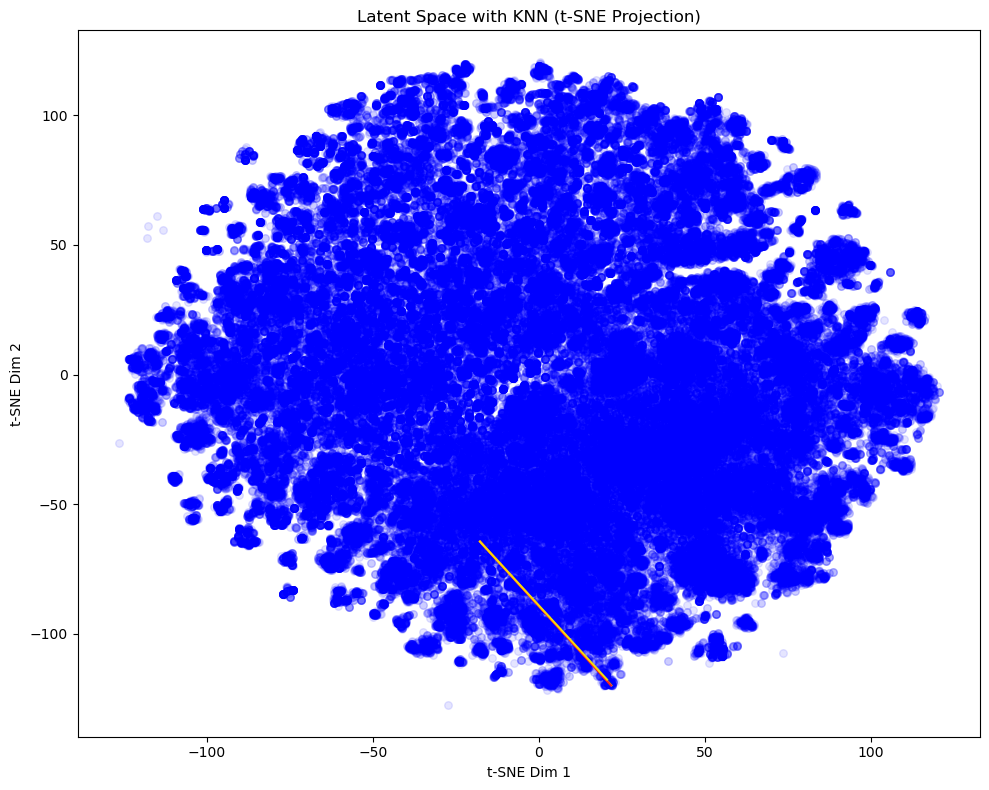

In [123]:
distances, indices = knn.kneighbors(encoded_input) # get the neighbours again

plt.figure(figsize=(10, 8)) # set up the plot
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=30, c='Blue', label='Latent Points',alpha=0.1) # display the t-SNE projection using alpha one to show dense areas
colours = ["yellow","red","pink","green","purple"]

for j in indices[0][1:]: #plot the each neighbours line with a different colour
    plt.plot(
        [latent_2d[i, 0], latent_2d[j, 0]],
        [latent_2d[i, 1], latent_2d[j, 1]],
        'k-', alpha=0.8,color=f"{colours.pop()}"
    )
plt.title("Latent Space with KNN (t-SNE Projection)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()